# DSCI-471 Final Project
## X-Ray Image Pneuomnia Detection
### Team: Vasyl Nesteryuk (vn357), Brett Musselman (bam429), Lu Liu, Katya Kasalobava  (kk3466)

## EDA

In [33]:
#import libraries
import requests
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import io

In [34]:
#import from custom modules
from scripts import data_loader

In [35]:
#read manifest of cloud storage
#grabbed using gsutil ls gs://dsci471/** > file_list.tx
doc_url = "file_list.txt"

In [36]:
#read in each line as an entry in a list
def read_lines_as_list(content):
    lines = content.splitlines()
    return [line.strip() for line in lines]

#read in the file
with open(doc_url, 'r') as file:
    list_doc = file.read()
list_of_files = read_lines_as_list(list_doc)

In [39]:
train_files = []
test_files = []
val_files = []

for file_name in list_of_files:
    if "gs://dsci471/reorg_80_10_10/train/" in file_name:
        train_files.append(file_name)
    elif "gs://dsci471/reorg_80_10_10/test/" in file_name:
        test_files.append(file_name)
    elif "gs://dsci471/reorg_80_10_10/val/" in file_name:
        val_files.append(file_name)
    else:
        continue

In [40]:
# Create dataframes for train, test, and val files
train_df = pd.DataFrame(train_files, columns=['file_path'])
test_df = pd.DataFrame(test_files, columns=['file_path'])
val_df = pd.DataFrame(val_files, columns=['file_path'])

# Extract labels (NORMAL or PNEUMONIA) from file paths
def extract_label(file_path):
    if '/NORMAL/' in file_path:
        return 'NORMAL'
    elif '/PNEUMONIA_BACTERIAL/' in file_path:
        return 'PNEUMONIA_BACTERIAL'
    elif '/PNEUMONIA_VIRAL/' in file_path:
        return 'PNEUMONIA_VIRAL'
    else:
        return 'UNKNOWN'

# Extract filename from path
def extract_filename(file_path):
    return file_path.split('/')[-1]

# Extract public url from path
def extract_public_url(file_path):
    return file_path.replace("gs://dsci471/", "https://storage.googleapis.com/dsci471/")

# Add label and filename columns to each dataframe
for df in [train_df, test_df, val_df]:
    df['label'] = df['file_path'].apply(extract_label)
    df['filename'] = df['file_path'].apply(extract_filename)
    df['public_url'] = df['file_path'].apply(extract_public_url)

# Add dataset type column
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
val_df['dataset'] = 'val'

# Combine all dataframes
all_files_df = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Display summary of the data
print(f"Total files: {len(all_files_df)}")
print(f"Train files: {len(train_df)}")
print(f"Test files: {len(test_df)}")
print(f"Val files: {len(val_df)}")

# Show distribution of labels
print("\nLabel distribution:")
print(all_files_df['label'].value_counts())

# Show the first few rows of the dataframe
all_files_df.head()


Total files: 5856
Train files: 4684
Test files: 587
Val files: 585

Label distribution:
label
PNEUMONIA_BACTERIAL    2780
NORMAL                 1583
PNEUMONIA_VIRAL        1493
Name: count, dtype: int64


,file_path,label,filename,public_url,dataset
0,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0001-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train
1,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0003-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train
2,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0005-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train
3,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0007-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train
4,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0009-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train


In [42]:
#add another column label_two to the dataframe
def label_two(row):
    label = row['label']
    file = row['filename']
    if label == 'NORMAL':
        return 0
    elif label == 'PNEUMONIA_BACTERIAL':
        return 1
    elif label == 'PNEUMONIA_VIRAL':
        return 2
    else:
        return -1
    
# Apply the function to create the new column
all_files_df['label_two'] = all_files_df.apply(label_two, axis=1)

print(all_files_df['label_two'].value_counts())

# Display the updated dataframe
all_files_df.head()

label_two
1    2780
0    1583
2    1493
Name: count, dtype: int64


,file_path,label,filename,public_url,dataset,label_two
0,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0001-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train,0
1,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0003-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train,0
2,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0005-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train,0
3,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0007-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train,0
4,gs://dsci471/reorg_80_10_10/train/NORMAL/IM-00...,NORMAL,IM-0009-0001.jpeg,https://storage.googleapis.com/dsci471/reorg_8...,train,0


There are 2780 cases of bacterial pneumonia, there are 1583 cases of no pneumonia, and then there are 1493 cases of viral pneumonia. This means that we don't have a balanced dataset. We will need to take this into account when we are training our model. Furthermore, we could simply focus on predicting pneumonia vs no pneumonia, or we could focus on predicting the type of pneumonia.

In [46]:
#randomly pull one normal image, one viral image, and one bacterial image
normal_image = all_files_df[all_files_df['label_two'] == 0].sample(1)
viral_image = all_files_df[all_files_df['label_two'] == 2].sample(1)
bacterial_image = all_files_df[all_files_df['label_two'] == 1].sample(1)

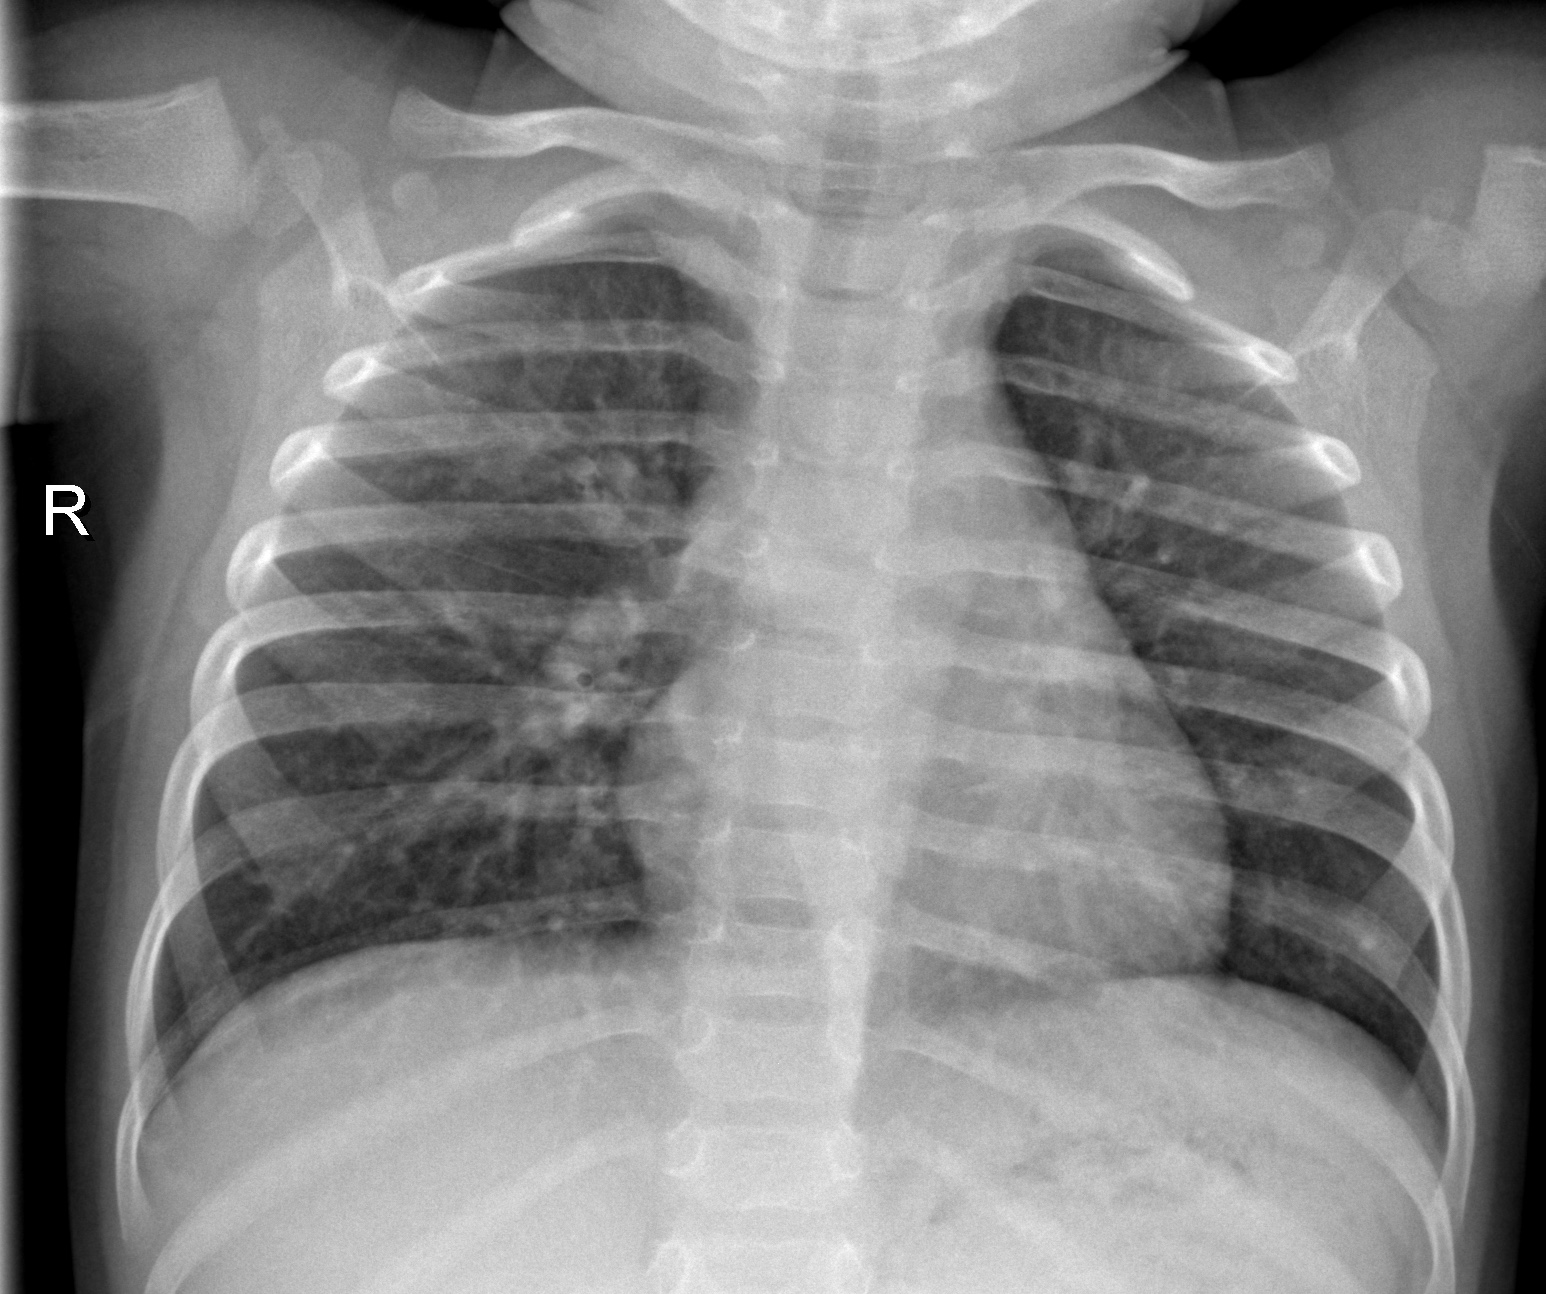

In [47]:
def load_jpeg_from_url(url: str) -> Image.Image:
    """
    Load a JPEG image from a URL into a PIL Image object.

    Args:
        url (str): Direct URL to a JPEG image.

    Returns:
        Image.Image: A PIL Image object.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise error for bad status
        image = Image.open(io.BytesIO(response.content))
        image.load()  # Force load image data
        return image
    except Exception as e:
        raise ValueError(f"Failed to load image from URL: {e}")
    
normal_image_url = normal_image['public_url'].values[0]
viral_image_url = viral_image['public_url'].values[0]
bacterial_image_url = bacterial_image['public_url'].values[0]

normal_image = load_jpeg_from_url(normal_image_url)
viral_image = load_jpeg_from_url(viral_image_url)
bacterial_image = load_jpeg_from_url(bacterial_image_url)

from IPython.display import display
display(normal_image)

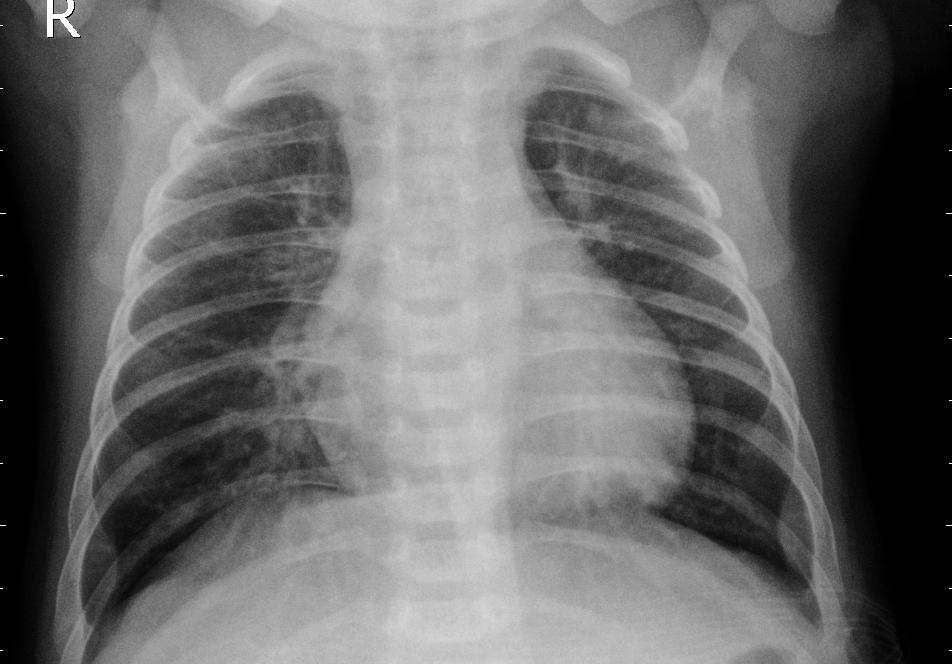

In [48]:
display(viral_image)

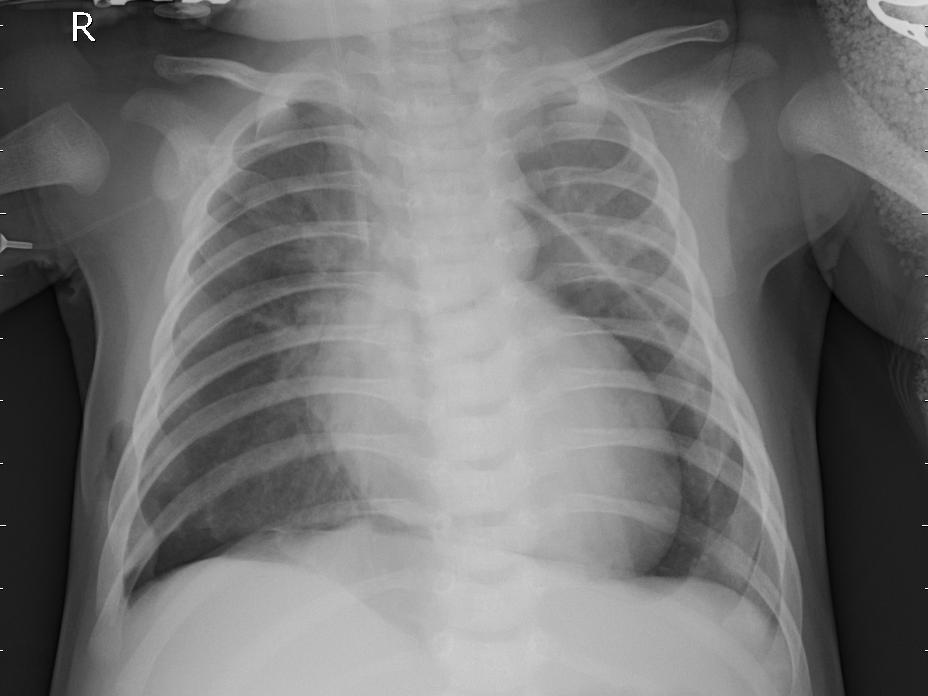

In [49]:
display(bacterial_image)

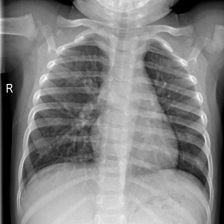

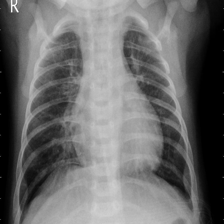

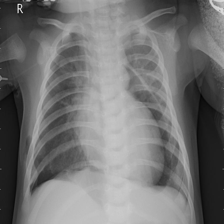

In [50]:
#resize the images to 224x224
normal_image = normal_image.resize((224, 224))
viral_image = viral_image.resize((224, 224))
bacterial_image = bacterial_image.resize((224, 224))

display(normal_image)
display(viral_image)
display(bacterial_image)

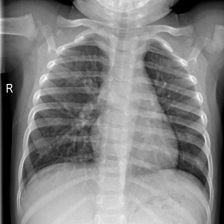

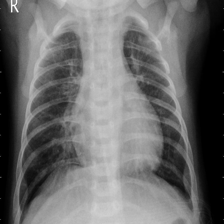

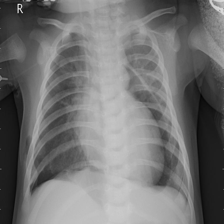

In [51]:
#Now convert to "L"
normal_image = normal_image.convert("L")
viral_image = viral_image.convert("L")
bacterial_image = bacterial_image.convert("L")

#display the images
display(normal_image)
display(viral_image)
display(bacterial_image)

It doesn't look like much signal is being lost when we resize the images and convert the images to grayscale. The pneumonia is still visible in the images as kind of a smudge.

In [52]:
#save the dataframe to csv in data
all_files_df.to_csv('data/all_files_df.csv', index=False)

## Initial Model Construction

See cnn_model.py for architecture. We can modify the base object we defined to make it easier but for now we should be able to train and test pretty easily. We may want to add a tune or optimize.py file.

## Training the Model

In [ ]:
!python scripts/train.py > train_output.txt
with open("train_output.txt") as f:
    print(f.read())

^C
No GPU detected. Training will run on CPU.
Epoch 1/20



2025-05-12 15:11:36.601924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 15:11:38.251749: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 15:11:42.819009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
c:\Users\BrettMusselman\repos\DSCI471-Final-Project\.venv\Lib\site-p

## Testing/Optimizng the Model

In [56]:
!python scripts/test.py > test_output.txt
with open("test_output.txt") as f:
    print(f.read())

No GPU detected. Testing will run on CPU.



The process cannot access the file because it is being used by another process.


## Conclusion